# Compare PIP of susie, DAP and CAVIAR

DAP and CAVIAR is performed on some of the same input data and is compared with `susie`.

In [17]:
%revisions -s

## Plan

Here I consider the following scenarios:

- Fix total PVE to 0.2
- Scenario with growing difficulty: from 1 causal to 5 causal

For CAVIAR I only try and report the 2 causal and 3 causal scenarios.

The plan is to get the PIP for those in susieR mappable CS (purity > 0.2), and compare these PIP to what DAP and CAVIAR reports. For susie flavors:

- use prior = 0.2
- use estimate_residule = False

This setting of susie should reflect its best performance. Additionally I check both the PIP computed before purity filter, and that after purity filter.

## Expected outcome

- PIP plots, 3-way: susie vs DAP, susie vs CAVIAR, DAP vs CAVIAR
- A coarse ROC plot: report signals identified vs signal missed -- number of causal, under the same PVE setup.

Previously I've ran this specific DSC using:

```
dsc susie.dsc --target run_comparison -o susie_comparison
```

So here I query from that result.

## Workflow

In [18]:
%run

cwd = path('~/GIT/github/mvarbvs/dsc')
dirname = path(f'{cwd:a}/susie_comparison/')
ld_col = 1
ld_cutoff = 0.2
pip_cutoff = 0.2

[pip_1]
output: f'{dirname}/PIP_comparison_0528.rds'
R: expand = '${ }', workdir = cwd
    dap_out = dscrutils::dscquery(${dirname:br}, 
                        target = "liter_data.dataset lm_less.pve lm_less.n_signal fit_dap plot_dap",
                             load.pkl = TRUE)
    susie_out = dscrutils::dscquery(${dirname:br}, 
                        target = "liter_data.dataset lm_less.pve lm_less.n_signal fit_susie.prior_var fit_susie.estimate_residual_variance fit_susie plot_susie",
                             load.pkl = TRUE)
    saveRDS(list(dap=dap_out, susie=susie_out), ${_output:r})

[pip_2]
pip_after_filter = ['FALSE', 'TRUE']
input: for_each = 'pip_after_filter'
output: f'{_input:n}.filter_{_pip_after_filter.lower()}.png'
R: stdout = f'{_output:n}.log', expand = '${ }', workdir = cwd
    ld_col = ${ld_col}
    ld_cutoff = ${ld_cutoff}
    pip_cutoff = ${pip_cutoff}

    dat = readRDS(${_input:r})
    dap_out = dat$dap
    susie_out = dat$susie
    # favorit susie flavor
    susie_out = susie_out[which(susie_out$fit_susie.prior_var == 0.2 & susie_out$fit_susie.estimate_residual_variance == FALSE), ]
    susie_out = subset(susie_out, select =-c(lm_less.pve, fit_susie.prior_var, fit_susie.estimate_residual_variance))

    data_sets = unique(susie_out$liter_data.dataset)
    signals = unique(susie_out$lm_less.n_signal)

    result = list()
    for (s in signals) {
        result[[as.character(s)]] = NULL
        print(paste('==============', s, '=============='))
        for (d in data_sets) {
            out_files = susie_out[which(susie_out$lm_less.n_signal == s & susie_out$liter_data.dataset == d),c("fit_susie.output.file", "plot_susie.output.file")]
            fit = readRDS(paste0(${dirname:r}, '/', out_files[1,1], '.rds'))$posterior
            purity = readRDS(paste0(${dirname:r}, '/', out_files[1,2], '.rds'))
            if (${_pip_after_filter}) {
              alpha = fit$alpha[[1]][which(purity$purity$V1[,ld_col] > ld_cutoff),,drop=FALSE]
            } else {
              alpha = fit$alpha[[1]]
            }
            pip = t(1 - apply(1 - alpha, 2, prod))
            in_CI = fit$in_CI[[1]]
            in_CI = in_CI[which(purity$purity$V1[,ld_col] > ld_cutoff),,drop=FALSE]
            in_CI = which(colSums(in_CI) > 0)
            pip = pip[in_CI]
            out_files = dap_out[which(dap_out$lm_less.n_signal == s & dap_out$liter_data.dataset == d),c("fit_dap.output.file"),drop=FALSE]
            dap = readRDS(paste0(${dirname:r}, '/', out_files[1,1], '.rds'))$posterior
            #caviar = readRDS(paste0(other_dirname, out_other[1,2], '.rds'))$posterior
            dap = dap$V0$snp
            print(head(dap, length(pip)))
            dap = dap[which(dap$snp %in% as.character(in_CI)),]
            print(dap)
            print(pip)        
            print(in_CI)
            #caviar = caviar[[1]]$snp
            pip = cbind(pip, as.vector(dap$snp_prob))
            if (is.null(result[[as.character(s)]])) {
                result[[as.character(s)]] = pip
            } else {
                result[[as.character(s)]] = rbind(result[[as.character(s)]], pip)
            }
        }
        result[[as.character(s)]] = data.frame(result[[as.character(s)]])
        colnames(result[[as.character(s)]]) = c('susie', 'dap')
    }

    png(${_output:r}, 600, 800)
    #par(mar=c(.5,.5,.5,.5))
    par(mfrow=c(3, 2))
    for (i in 1:5) {
        i = as.character(i)
        x = result[[i]][result[[i]]$susie > pip_cutoff & result[[i]]$dap > pip_cutoff,]
        plot(x[,1], x[,2], xlab = paste('PIP susie >', pip_cutoff), ylab = paste('PIP DAP >', pip_cutoff),
             main = paste('num. causal:', i, '\ncor:', round(cor(x)[1,2],2)),
            col = '#002b36', pch = 20)
        abline(0,1,col=2)
    }
    dev.off()

INFO: pip_1 (index=0) is ignored due to saved signature


> /home/gaow/GIT/github/mvarbvs/dsc/susie_comparison/PIP_comparison_0528.filter_true.png (36.3 KiB):

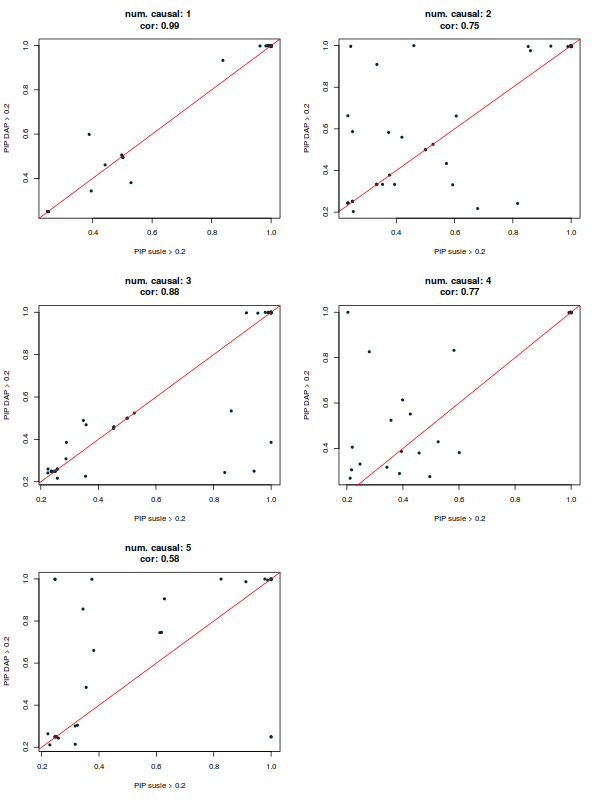

In [13]:
%preview ~/GIT/github/mvarbvs/dsc/susie_comparison/PIP_comparison_0528.filter_true.png

> /home/gaow/GIT/github/mvarbvs/dsc/susie_comparison/PIP_comparison_0528.filter_false.png (37.9 KiB):

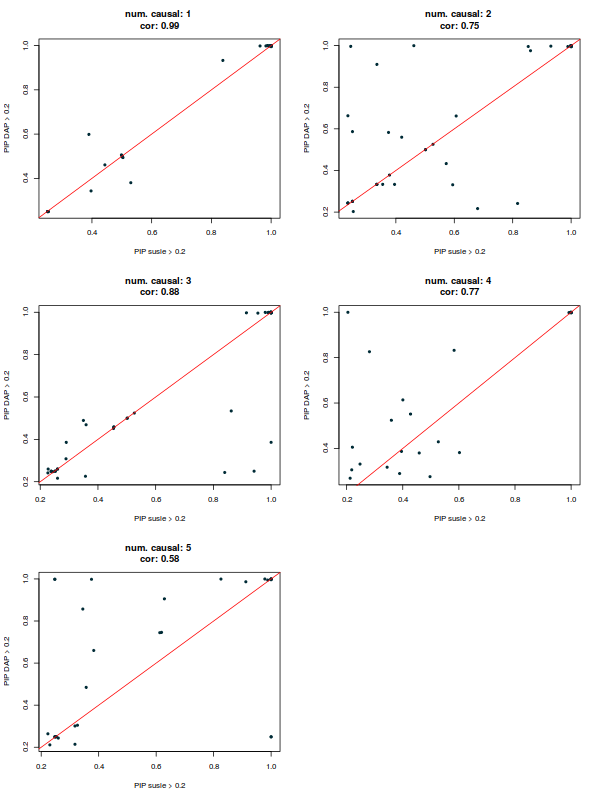

In [14]:
%preview ~/GIT/github/mvarbvs/dsc/susie_comparison/PIP_comparison_0528.filter_false.png